# Decision Making Under Uncertainty - Assignment 1

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

In [5]:
import random
import math
import itertools
import re

import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb
from scipy import stats

In [6]:
# Set parameters
num_instances = 10
num_items = 10
g = 2 # group number
alpha_model = {"EV": 0, "CVaR": 0.95}
beta_model = {"EV": 0, "CVaR": 1}

# Generation of Problem Instances
## Part 1
In the first part, we want to generate 10 random instances of the Stochastic Knapsack Problem (SKP). For this, we need to generate values for the low weights using the Poisson distribution. From Lab 2, we know that the `numpy.random` library is the fastest in doing this. For the high weights, we will use the same library, using the `triangular()` function from `numpy.random`.


In [7]:
def generate_instance(num_items, g, seed):
    """Generate a dictionary of `num_items` possible item sizes

    Parameters
    ----------
    num_items : int
        Number of items to generate weights for
    g : int
        Group number
    seed : int
        Random seed

    Returns
    -------
    item_sizes : dict
        Dictionary containing the possible item sizes
    """

    # Assert inputs are of correct form
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"
    assert isinstance(seed, int), "seed is not an int"

    # Generate possible item sizes.
    np.random.seed(seed)
    lam = [math.ceil((i + 1)/2) for i in range(num_items)]
    dl = np.minimum(np.random.poisson(lam), 10)
    dh = [np.random.triangular(90 + g - (i+1), 100 + g - (i+1), 110 + g - (i+1))
          for i in range(num_items)]

    item_sizes = {"dl": dl, "dh": dh}

    return item_sizes


def skp(num_instances, num_items, g):
    """Generates `num_instances` instances of a Stochastic Knapsack Problem (SKP).

    Parameters
    ----------
    num_instances : int
        Number of instances of the SKP to generate
    num_items : int
        Number of items to consider per instance
    g : int
        Group number

    Returns
    -------
    instance : tuple
        Tuple containing the unit excess weight penalty `p`, knapsack capacity `K`, item size
        probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`,
        respectively.
    """

    # Assert inputs are of correct form
    assert isinstance(num_instances, int), "num_instances is not an int"
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"

    # Generate instance variables
    p = math.floor(60 + 0.1 * g)  # Unit excess weight penalty
    K = 400 + 4 * g  # Knapsack capacity

    pi = np.asarray([0.5 + 0.05 * (i + 1) - 0.001 for i in range(num_items)])  # Item size probabilities
    r = np.asarray([51 - (i + 1) for i in range(num_items)])  # Revenues

    item_sizes = {j: generate_instance(num_items, g, seed=j) for j in range(num_instances)}  # dl, dh

    instance = (p, K, pi, r, item_sizes)

    return instance

In [8]:
p, K, pi, r, item_sizes = skp(num_instances, num_items, g)
print(pi)

[0.549 0.599 0.649 0.699 0.749 0.799 0.849 0.899 0.949 0.999]


# Heuristic Algorithm
## Part 2

In [9]:
def greedy_algorithm(problem_instance, pi, r, item_sizes, K):
    """Generates a selection vector for an SKP based on a greedy approach.

    Parameters
    ----------
    problem_instance : int
        Integer indicating which instance to take
    pi : list
        List of probabilities whether an item will attain a high weight
    g : int
        Group number

    Returns
    -------
    instance : tuple
        Tuple containing the unit excess weight penalty `p`, knapsack capacity `K`, item size
        probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`,
        respectively.
    """

    # Compute expectation of w_i for each item
    Ew = item_sizes[problem_instance]["dh"] * np.array(pi) + item_sizes[problem_instance]["dl"] * (np.array(1) - pi)
        
    sorted_expected_revenue = np.argsort(r)[::-1]

    # Initialise zero-value x and W
    x = np.zeros(10, dtype=np.int16)
    W = 0

    while len(sorted_expected_revenue) != 0:

        consider_item = sorted_expected_revenue[0]

        if W + Ew[consider_item] <= K:
            x[consider_item] = 1
            W = W + Ew[consider_item]

        sorted_expected_revenue = np.delete(sorted_expected_revenue, 0)

    return x

# Monte Carlo Simulation
## Part 3

In [10]:
problem_instance = 0
x = greedy_algorithm(problem_instance, pi, r, item_sizes, K)
print("x:", x)

x: [1 1 1 1 1 1 0 0 0 0]


In [11]:
def calculate_profits(item_sizes, x, r, pi, num_items, num_runs, problem_instance):

    profits = []

    for run in range(num_runs):
        u = np.random.uniform(size=num_items)
        w = [item_sizes[problem_instance]["dh"][i] if u[i] < pi[i] else item_sizes[problem_instance]["dl"][i]
            for i in range(num_items)]
        w = np.asarray(w)

        total_weight = np.dot(x, w)
        excess = max(total_weight-K, 0)

        profit = np.dot(x, r*w) - excess*p
        profits.append(profit)

    profits = sorted(profits)

    return profits

We want to calculate the optimal number of runs for running our Monte Carlo simulation. For this, we need to first get an estimate for the standard deviation of the distribution of the profits...

In [12]:
# Calculate number of runs; first a test run to get an estimate for sigma
profits = calculate_profits(item_sizes, x, r, pi, num_items, num_runs=1000, problem_instance=problem_instance)
sigma = np.std(profits)
print("sigma:", sigma)

sigma: 4882.083461004353


We'd like to show the distribution of the profits. Due to the jumps between selecting a certain number of high and low weights, the distribution looks highly irregular. As such, results may not necessarily be reliable. Nonetheless, as advised by the lecturer, we still take the approach as discussed in the first few lectures. 

(Perhaps better to replace this section by a plot of the distribution of the sample mean)

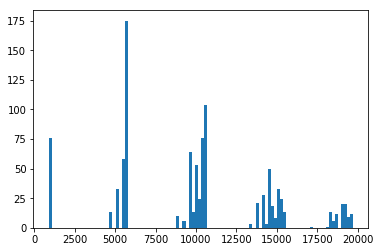

In [13]:
plt.hist(profits, bins=100)
plt.show()

We then select a value for `alpha` equal to 0.05 as the confidence level for our preferred half-width, defined by `epsilon`. This then gives us the desired number of runs:

In [14]:
alpha = 0.05
z = stats.norm.ppf(1-alpha/2)

epsilon = 0.01*np.mean(profits) # half-width
n = int(np.ceil((z*sigma/epsilon)**2))
print("n:", n)

n: 9366


Next, we find the profits for this number of runs `n` and the corresponding confidence interval for the sample mean.

In [15]:
# Now find profits for this number of runs...
profits = calculate_profits(item_sizes, x, r, pi, num_items, num_runs=n, problem_instance=problem_instance)

# and find the confidence interval
half_width = z*sigma/math.sqrt(n)
confidence_interval = (np.mean(profits) - half_width, np.mean(profits) + half_width)
print("Confidence interval:", confidence_interval)

Confidence interval: (9706.520244067955, 9904.26556206477)


# Stochastic Programming Models
## Part 4.

The model: 
\begin{align*}
    \max_{x, \varepsilon_u,\eta, S_u } \; (1-\beta) \left [ \sum_{u \in U} P_u \left ( \sum_{i=1}^{10} r_i w_{iu} x_i - p \varepsilon_u \right ) \right ] + \beta \left [ \eta - \frac{1}{1-\alpha} \sum_{u \in U } P_u S_u \right ]
\end{align*}
subject to 
\begin{align*}
    \begin{aligned}
     x_i & \in \{0,1\} & \quad & \text{ for all } i \in I \\
     \varepsilon_u & \geq 0 & \quad & \text{ for all } u \in U \\
    \varepsilon_u & \geq \sum_{i=1} ^{10} w_{iu} x_i - K  & \quad &  \text{ for all } u \in U \\
    S_u & \geq 0 & \quad & \text{ for all } u \in U \\
    S_u & \geq \eta - \left ( \sum_{i=1}^{10} r_i w_{iu} x_i - p \varepsilon_u \right ) & \quad & \text{ for all } u \in U.
\end{aligned}
\end{align*}


In [16]:
# For testing purposes
scenario1 = [item_sizes[problem_instance]['dh'][i] if (i % 2 == 0) else item_sizes[problem_instance]['dl'][i] for i in range(num_items)]
scenario2 = [item_sizes[problem_instance]['dl'][i] if (i % 2 == 0) else item_sizes[problem_instance]['dh'][i] for i in range(num_items)]
scenario3 = [item_sizes[problem_instance]['dl'][i] if i <= 4 else item_sizes[problem_instance]['dh'][i] for i in range(num_items)]

scenario_weights = (scenario1, scenario2, scenario3)
scenario_probabilities = (1/3, 1/3, 1/3)

In [17]:
#### Create all 1024 scenarios ####
# Binary scenarios creates all possible permutations of 0 and 1
def create_scenarios(problem_instance):
    binary_scenarios = [list(i) for i in itertools.product([0, 1], repeat=num_items)]

    # We will, without loss of generality, define that a 1 in binary_scenarios corresponds with a high weight
    scenario_weights = [[item_sizes[problem_instance]['dh'][i] if scenario[i] == 1
                         else item_sizes[problem_instance]['dl'][i]
                         for i in range(num_items)]
                        for scenario in binary_scenarios]
    scenario_probabilities = [np.prod([pi[i] if scenario[i] == 1 else (1-pi[i])
                                       for i in range(num_items)])
                              for scenario in binary_scenarios]
    
    return scenario_weights, scenario_probabilities

## Model formulation in Gurobi

In [18]:
def gurobi_optimization(problem_instance,beta,alpha,r,p,K):

    # Generate scenarios for problem instance
    scenario_weights, scenario_probabilities = create_scenarios(problem_instance)
    
    # Misc
    items = range(num_items)
    scenarios = range(len(scenario_weights))

    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Create empty model
    m = gb.Model()

    # Create variables 
    x = m.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    eta = m.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    epsilon = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0) 
    s = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    # Set objective function
    def scenario_profit(scenario):
        return gb.quicksum(r[item]*scenario_weights[scenario][item]*x[item]-p*epsilon[scenario] for item in items)

    obj_1 = (1-beta)*gb.quicksum(scenario_probabilities[scenario]*scenario_profit(scenario) for scenario in scenarios)
    obj_2 = beta*(eta[0]-(1/(1-alpha))*gb.quicksum(scenario_probabilities[scenario]*s[scenario] for scenario in scenarios))

    m.setObjective(obj_1 + obj_2, gb.GRB.MAXIMIZE)

    # # Create constraints
    # Epsilon constraint
    for scenario in scenarios:
        m.addConstr(epsilon[scenario] >= gb.quicksum(scenario_weights[scenario][item]*x[item] for item in items) - K)

    # S constraint
    for scenario in scenarios:
        m.addConstr(s[scenario] >= eta[0] - scenario_profit(scenario))

    # Solve model
    m.optimize()
    
    return m

## Part 5.

In [19]:
# Solve EV model
model_solves_EV = [gurobi_optimization(instance,beta_model["EV"],alpha_model,r,p,K) for instance in range(num_instances)]
# model_solves_EV = gurobi_optimization(0,beta_model["EV"],alpha_model["EV"],r,p,K)

Academic license - for non-commercial use only
Optimize a model with 2048 rows, 2059 columns and 24576 nonzeros
Variable types: 2049 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [4e-07, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective 12439.601931
Presolve removed 1319 rows and 1320 columns
Presolve time: 0.04s
Presolved: 729 rows, 739 columns, 8019 nonzeros
Variable types: 721 continuous, 18 integer (18 binary)

Root relaxation: objective 1.593004e+04, 79 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 15930.0441    0    1 12439.6019 15930.0441  28.1%     -    0s
H    0     0                    14469.044380 15930.0441  10.1%     -    0s
H    0     0                    14495.419726 15930.0441  9.90%     -    0s
     0  

     0     0 15707.3325    0    3 14983.2082 15707.3325  4.83%     -    0s
     0     0 15678.1460    0    3 14983.2082 15678.1460  4.64%     -    0s
     0     0 15631.4212    0    5 14983.2082 15631.4212  4.33%     -    0s
     0     0 15586.1165    0    5 14983.2082 15586.1165  4.02%     -    0s
     0     0 15572.9311    0    6 14983.2082 15572.9311  3.94%     -    0s
     0     0 15531.8213    0    7 14983.2082 15531.8213  3.66%     -    0s
     0     0 15464.3503    0    6 14983.2082 15464.3503  3.21%     -    0s
     0     0 15436.5578    0    6 14983.2082 15436.5578  3.03%     -    0s
     0     0 15273.4760    0    7 14983.2082 15273.4760  1.94%     -    0s
     0     0 15240.2275    0    8 14983.2082 15240.2275  1.72%     -    0s
     0     0 infeasible    0      14983.2082 14983.2082  0.00%     -    0s

Cutting planes:
  Cover: 4
  MIR: 3

Explored 1 nodes (79 simplex iterations) in 0.20 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 14983.2 14884 

     0     0 15511.0158    0    7 14315.6325 15511.0158  8.35%     -    0s
     0     0 15501.2393    0    7 14315.6325 15501.2393  8.28%     -    0s
     0     0 15480.8588    0    7 14315.6325 15480.8588  8.14%     -    0s
     0     0 15471.9333    0    8 14315.6325 15471.9333  8.08%     -    0s
     0     0 15465.9972    0    8 14315.6325 15465.9972  8.04%     -    0s
     0     0 15464.7681    0    6 14315.6325 15464.7681  8.03%     -    0s
     0     0 15460.6274    0    6 14315.6325 15460.6274  8.00%     -    0s
     0     0 15426.7510    0    5 14315.6325 15426.7510  7.76%     -    0s
     0     0 15420.1235    0    7 14315.6325 15420.1235  7.72%     -    0s
     0     0 15413.6144    0    7 14315.6325 15413.6144  7.67%     -    0s
     0     0 15406.6499    0    8 14315.6325 15406.6499  7.62%     -    0s
     0     0 15405.9262    0    8 14315.6325 15405.9262  7.62%     -    0s
     0     0 15403.8665    0    5 14315.6325 15403.8665  7.60%     -    0s
     0     0 15380.7395  

In [20]:
# Solve CVaR mode
model_solves_CVaR = [gurobi_optimization(instance, beta_model["CVaR"], alpha_model, r, p, K) for instance in range(num_instances)]
# model_solves_CVaR = gurobi_optimization(0, beta_model["EV"], alpha_model["CVaR"], r, p, K)

Optimize a model with 2048 rows, 2059 columns and 24576 nonzeros
Variable types: 2049 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 295 rows and 295 columns
Presolve time: 0.03s
Presolved: 1753 rows, 1764 columns, 21036 nonzeros
Variable types: 1754 continuous, 10 integer (10 binary)

Root relaxation: objective 1.151673e+04, 1104 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11516.7302    0    9   -0.00000 11516.7302      -     -    0s
H    0     0                    9689.9499011 11516.7302  18.9%     -    0s
     0     0 10437.9781    0    9 9689.94990 10437.9781  7.72%     -    0s
     0     0 10432.5196    0    9 9689.94990 10432.51

     0     0 10655.6491    0    9 10031.3586 10655.6491  6.22%     -    1s
     0     0 10654.6936    0    9 10031.3586 10654.6936  6.21%     -    1s
     0     0 10654.4268    0    9 10031.3586 10654.4268  6.21%     -    1s
     0     0 10654.4220    0    9 10031.3586 10654.4220  6.21%     -    1s
     0     0 10650.0034    0    9 10031.3586 10650.0034  6.17%     -    1s
     0     0 10649.9550    0    9 10031.3586 10649.9550  6.17%     -    1s
     0     0 10648.2933    0    9 10031.3586 10648.2933  6.15%     -    1s
     0     0 10648.1031    0    9 10031.3586 10648.1031  6.15%     -    1s
     0     0 10647.6113    0    9 10031.3586 10647.6113  6.14%     -    1s
     0     0 10647.0979    0    9 10031.3586 10647.0979  6.14%     -    2s
     0     0 10647.0388    0    9 10031.3586 10647.0388  6.14%     -    2s
     0     0 10645.8291    0    9 10031.3586 10645.8291  6.13%     -    2s
     0     0 10645.3078    0    9 10031.3586 10645.3078  6.12%     -    2s
     0     0 10645.1098  

     0     0 10207.4624    0    9 9537.58137 10207.4624  7.02%     -    0s
     0     0 10207.1907    0    9 9537.58137 10207.1907  7.02%     -    0s
     0     0 10204.6845    0    9 9537.58137 10204.6845  6.99%     -    0s
     0     0 10203.2941    0    9 9537.58137 10203.2941  6.98%     -    0s
     0     0 10203.0859    0    9 9537.58137 10203.0859  6.98%     -    1s
     0     0 10202.9729    0    9 9537.58137 10202.9729  6.98%     -    1s
     0     0 10194.2819    0    9 9537.58137 10194.2819  6.89%     -    1s
     0     0 10192.9335    0    9 9537.58137 10192.9335  6.87%     -    1s
     0     0 10192.6953    0    9 9537.58137 10192.6953  6.87%     -    1s
     0     0 10192.3764    0    9 9537.58137 10192.3764  6.87%     -    1s
     0     0 10192.3417    0    9 9537.58137 10192.3417  6.87%     -    1s
     0     0 10188.5100    0    9 9537.58137 10188.5100  6.82%     -    1s
     0     0 10186.6428    0    9 9537.58137 10186.6428  6.81%     -    1s
     0     0 10186.3786  

Optimize a model with 2048 rows, 2059 columns and 23552 nonzeros
Variable types: 2049 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 313 rows and 313 columns
Presolve time: 0.03s
Presolved: 1735 rows, 1746 columns, 20022 nonzeros
Variable types: 1736 continuous, 10 integer (10 binary)

Root relaxation: objective 1.122744e+04, 1077 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11227.4409    0    8   -0.00000 11227.4409      -     -    0s
H    0     0                    9782.8862364 11227.4409  14.8%     -    0s
     0     0 10287.0263    0    9 9782.88624 10287.0263  5.15%     -    0s
     0     0 10286.2077    0    9 9782.88624 10286.20

     0     0 10578.2508    0    9 10004.3120 10578.2508  5.74%     -    3s
     0     0 10577.9540    0    9 10004.3120 10577.9540  5.73%     -    4s
     0     0 10577.9401    0    9 10004.3120 10577.9401  5.73%     -    4s
     0     0 10577.9173    0    9 10004.3120 10577.9173  5.73%     -    4s
     0     2 10577.9173    0    9 10004.3120 10577.9173  5.73%     -    4s

Cutting planes:
  Gomory: 3
  Cover: 1
  MIR: 58

Explored 7 nodes (2140 simplex iterations) in 4.47 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 10004.3 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000431202582e+04, best bound 1.000431202582e+04, gap 0.0000%
Optimize a model with 2048 rows, 2059 columns and 23552 nonzeros
Variable types: 2049 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e-08, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objecti

     0     0 10170.7608    0    9 9526.20373 10170.7608  6.77%     -    0s
     0     0 10166.0775    0    9 9526.20373 10166.0775  6.72%     -    0s
     0     0 10165.7253    0    9 9526.20373 10165.7253  6.71%     -    0s
     0     0 10165.6131    0    9 9526.20373 10165.6131  6.71%     -    0s
     0     0 10162.2339    0    9 9526.20373 10162.2339  6.68%     -    1s
     0     0 10162.0922    0    9 9526.20373 10162.0922  6.68%     -    1s
     0     0 10150.4507    0    9 9526.20373 10150.4507  6.55%     -    1s
     0     0 10149.9051    0    9 9526.20373 10149.9051  6.55%     -    1s
     0     0 10148.6497    0    9 9526.20373 10148.6497  6.53%     -    1s
     0     0 10147.8570    0    9 9526.20373 10147.8570  6.53%     -    1s
     0     0 10147.7934    0    9 9526.20373 10147.7934  6.53%     -    1s
     0     0 10147.0473    0    9 9526.20373 10147.0473  6.52%     -    1s
     0     0 10146.3834    0    9 9526.20373 10146.3834  6.51%     -    1s
     0     0 10146.3819  

In [21]:
try:
    for j in range(num_instances):
        v_EV = model_solves_EV[j].getVars()
        v_CVaR = model_solves_CVaR[j].getVars()

        outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
        outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
        outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
        outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

        print("Result for instance", j+1)
        print("Maximum objective value: ", model_solves_EV[j].Objval)
        print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
        print("")
        print("Maximum objective value: ", model_solves_CVaR[j].Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print("")
except TypeError:
    v_EV = model_solves_EV.getVars()
    v_CVaR = model_solves_CVaR.getVars()

    outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
    outcome_eta_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "eta")]
    outcome_epsilon_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "epsilon")]
    outcome_s_EV = [int(v_EV[i].x) for i in range(len(v_EV)) if (re.sub("\[\d+\]", "", v_EV[i].varName) == "s")]

    outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
    outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
    outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
    outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR)) if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

    print("Maximum objective value: ", model_solves_EV.Objval)
    print("EV   | x:", outcome_x_EV, "| eta:", outcome_eta_EV)
    print("")
    print("Maximum objective value: ", model_solves_CVaR.Objval)
    print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
    print("")

Result for instance 1
Maximum objective value:  14629.374682536607
EV   | x: [0, 0, 0, 1, 0, 0, 0, 1, 1, 1] | eta: [0]

Maximum objective value:  9689.949901109063
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [11661]

Result for instance 2
Maximum objective value:  15339.808183792346
EV   | x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1] | eta: [0]

Maximum objective value:  10031.358582811823
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [12107]

Result for instance 3
Maximum objective value:  15039.997476211218
EV   | x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1] | eta: [0]

Maximum objective value:  9769.45455698534
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [11899]

Result for instance 4
Maximum objective value:  14310.844199467268
EV   | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [0]

Maximum objective value:  9537.581366271468
CVar | x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1] | eta: [11531]

Result for instance 5
Maximum objective value:  14983.208156931087
EV   | x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1] | eta: [

## Part 6. 

In [18]:
# Analysis 

# Sample Average Approximation
## Part 7.

# Bonus question

## OLD

In [19]:
def gurobi_model(r, K, p,scenario_weights, scenario_probabilities, beta=0, alpha=0.95, save_path=None):
    model = gb.Model("expected_value")
    
    num_items = len(scenario_weights[0])
    
    items = range(num_items)
    scenarios = range(len(scenario_weights))
    
    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]
    
    # Define variables
    x = model.addVars(items, vtype=gb.GRB.BINARY, name= "x")
    epsilon = model.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0)
    eta = model.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    s = model.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    model.update()

    #### Write objective ####
    obj = gb.LinExpr()

    # Expected value objective
    for scenario in scenarios:
        for item in items:
            obj += (1-beta)*scenario_probabilities[scenario]*r[item]*scenario_weights[scenario][item]*x[item]
        obj -= (1-beta)*p*epsilon[scenario]

    # CVaR Objective:
    # Part 1
    obj += beta*eta[0]

    # Part 2
    for scenario in scenarios:
        # TODO: ask why we do 1/(1-a); what does it mean in practice (with relation to quantile)
        obj -= beta*(1/(1-alpha))*scenario_probabilities[scenario]*s[scenario]

    model.setObjective(obj, gb.GRB.MAXIMIZE)

    #### Write constraints ####
    # Epsilon constraint
    for scenario in scenarios:
        model.addConstr(epsilon[scenario] >= sum([scenario_weights[scenario][item]*x[item] for item in items]) - K,
                        name=f"epsilon_constraint_scenario_{scenario}")

    # S constraint
    for scenario in scenarios:
        model.addConstr(s[scenario] >= eta[0] - (sum([r[item]*scenario_weights[scenario][item]*x[item] for item in items])
                                                 - p*epsilon[scenario]),
                        name=f"s_constraint_scenario_{scenario}")
    
    # Update and, possibly, save model before optimising
    model.update()
    
    if save_path != None:
        model.write(f'{save_path}.lp')
        
    model.optimize()
    
    return model

In [20]:
# # Part 5
# # Part 6

# Sample Average Approximation
# # Part 7

# Analysis
# # Part 8

# # Part 9

# # Bonus